## Customer Churn Retention
Problem Statement and Technology Used

The objective of this project is to analyze customer churn patterns and identify key factors contributing to customer retention. We utilize Classification and Regression Trees (CART), a form of decision tree algorithm, to predict whether a customer is likely to churn based on their feedback and past engagement. The insights derived from this analysis will be used to improve customer retention strategies.

In [ ]:
# Installing packages
! pip install gspread
! pip install gspread-dataframe
! pip install oauth2client

In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.feature_selection import RFE


### Prepare and Train Model on Existing Data  

In [ ]:
# # Mounting Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Reading the dataset
df = pd.read_excel('customer data.xlsx')

In [3]:
# Displaying the data
df

,Name,CustomerID,Website,Security,Services,Delivery,Shopping,Price,FutureShop,Churn
0,John,C001,Good,Good,Good,Efficient,Reliable,Affordable,Yes,No
1,Alice,C002,Good,Very Good,Good,Normal,Normal,Unfair,Yes,Yes
2,Mike,C003,Bad,Bad,Good,Confusing,Unreliable,Very Good,No,Yes
3,Rose,C004,Good,Very Good,Very Good,Normal,Reliable,Unfair,Yes,Yes
4,Sam,C005,Very Good,Good,Bad,Confusing,Unreliable,Unfair,No,No
5,Lily,C006,Very Bad,Good,Good,Normal,Unreliable,Very Good,No,Yes
6,Chris,C007,Very Good,Good,Very Good,Confusing,Unreliable,Unfair,No,Yes
7,David,C008,Good,Very Good,Bad,Normal,Reliable,Affordable,Yes,No
8,Anna,C009,Bad,Good,Good,Confusing,Reliable,Very Good,No,Yes
9,Tony,C010,Good,Very Good,Very Good,Efficient,Reliable,Affordable,Yes,No


In [4]:
print(df.columns.tolist())  # Check exact column names


['Name', 'CustomerID', 'Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price', 'FutureShop', 'Churn']


In [5]:
# Mapping the options to numbers for easier model training
mapping_dict = {
    'Very Bad': 1, 'Bad': 2, 'Good': 3, 'Very Good': 4,
    'Confusing': 1, 'Normal': 2, 'Efficient': 3,
    'Unreliable': 1, 'Normal': 2, 'Reliable': 3,
    'Unfair': 1, 'Affordable': 2, 'Very Good': 3,
    'No': 0, 'Maybe': 1, 'Yes': 2
}
columns_to_map = ['Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price', 'FutureShop']
for col in columns_to_map:
    df[col] = df[col].map(mapping_dict)


In [6]:
df.head()

,Name,CustomerID,Website,Security,Services,Delivery,Shopping,Price,FutureShop,Churn
0,John,C001,3,3,3,3,3,2,2,No
1,Alice,C002,3,3,3,2,2,1,2,Yes
2,Mike,C003,2,2,3,1,1,3,0,Yes
3,Rose,C004,3,3,3,2,3,1,2,Yes
4,Sam,C005,3,3,2,1,1,1,0,No


In [12]:
# dropping unnecessary columns
df=df.drop(columns=['Name','CustomerID'])

## EDA And Statistical Summary

In [ ]:
# Display first few rows
print(df.head())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check data types
print("\nData Types:\n", df.dtypes)

# Basic statistics
print("\nStatistical Summary:\n", df.describe())


   Website  Security  Services  Delivery  Shopping  Price  FutureShop Churn
0        3         3         3         3         3      2           2    No
1        3         3         3         2         2      1           2   Yes
2        2         2         3         1         1      3           0   Yes
3        3         3         3         2         3      1           2   Yes
4        3         3         2         1         1      1           0    No

Missing Values:
 Website       0
Security      0
Services      0
Delivery      0
Shopping      0
Price         0
FutureShop    0
Churn         0
dtype: int64

Data Types:
 Website        int64
Security       int64
Services       int64
Delivery       int64
Shopping       int64
Price          int64
FutureShop     int64
Churn         object
dtype: object

Statistical Summary:
          Website  Security   Services   Delivery   Shopping      Price  \
count  20.000000  20.00000  20.000000  20.000000  20.000000  20.000000   
mean    2.400000  

The dataset contains 20 records with no missing values. Each feature along with its mean, median and quartiles are shown above.

## Data Preprocessing and Model Training

In [13]:
# Preparing features and target
X = df[['Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price','FutureShop']]
y = df['Churn']
print("Class Distribution in Dataset:")
print(df['Churn'].value_counts())


# Split data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Decision Tree (CART)
cart_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4,class_weight='balanced', random_state=42)
cart_model.fit(X_train, y_train)

y_pred_cart = cart_model.predict(X_test)
accuracy_cart = accuracy_score(y_test, y_pred_cart)
print(f" CART Model Accuracy: {accuracy_cart * 100:.2f}%")


Class Distribution in Dataset:
Churn
Yes    11
No      9
Name: count, dtype: int64
 CART Model Accuracy: 66.67%


### Hyperparameter Tuning
Using GridSreachCV to improve model performance

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='gini', random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all CPU cores for speed
)

# Fit GridSearch
grid_search.fit(X_train, y_train)

#  Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

#  Get the best model
best_cart_model = grid_search.best_estimator_

y_pred_best_cart = best_cart_model.predict(X_test)
accuracy_cart = accuracy_score(y_test, y_pred_best_cart)
print(f" Optimised CART Model Accuracy: {accuracy_cart * 100:.2f}%")

Best Parameters: {'max_depth': 4, 'min_samples_leaf': 1}
Best Cross-Validation Accuracy: 0.8
 Optimised CART Model Accuracy: 83.33%


In [ ]:
# Top 5 features
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['Website', 'Security', 'Services', 'Delivery', 'Shopping'], dtype='object')


Classification Report:
               precision    recall  f1-score   support

          No       0.50      1.00      0.67         1
         Yes       1.00      0.80      0.89         5

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



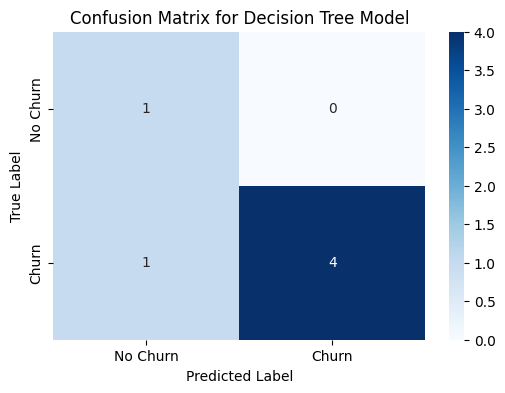

In [ ]:
# Compute classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best_cart))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_cart), annot=True, fmt="d", cmap="Blues", xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix for Decision Tree Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

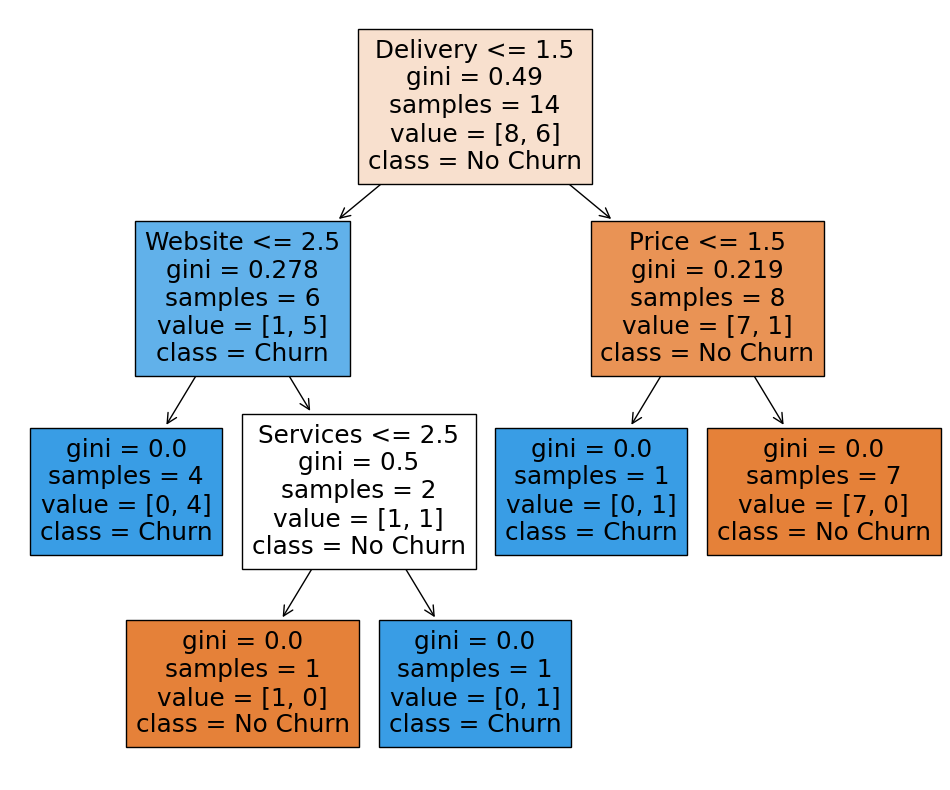


Feature Importances (Most important to least):
Website: 0.0972
Security: 0.0000
Services: 0.1458
Delivery: 0.5017
Shopping: 0.0000
Price: 0.2552
FutureShop: 0.0000


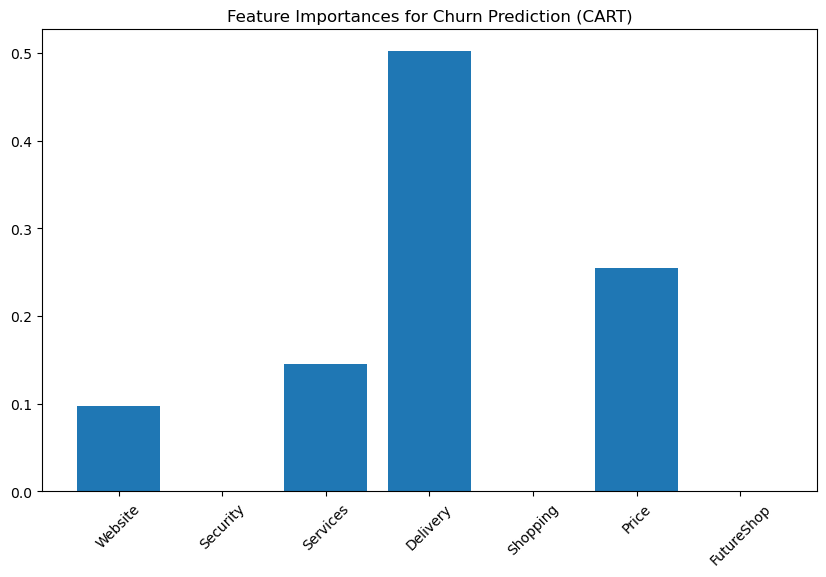

In [15]:
# Plot Decision Tree
plt.figure(figsize=(12, 10))
plot_tree(best_cart_model, feature_names=X.columns, class_names=["No Churn", "Churn"], filled=True)
plt.show()

# Feature Importance (CART)
importances_cart = best_cart_model.feature_importances_
print("\nFeature Importances (Most important to least):")
for col, score in zip(X.columns, importances_cart):
    print(f"{col}: {score:.4f}")
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances_cart)
plt.xticks(range(X.shape[1]), X.columns, rotation=45)
plt.title("Feature Importances for Churn Prediction (CART)")
plt.show()

Based on the model evaluation, it is revealed that Delivery is the most significant factor, followed by price and services.
Adjusting these would help with customer retention

## Experimenting with the Random Forest Classifier

Random Forest Accuracy (reduced overfitting): 66.67%
 Random Forest Accuracy: 66.67%


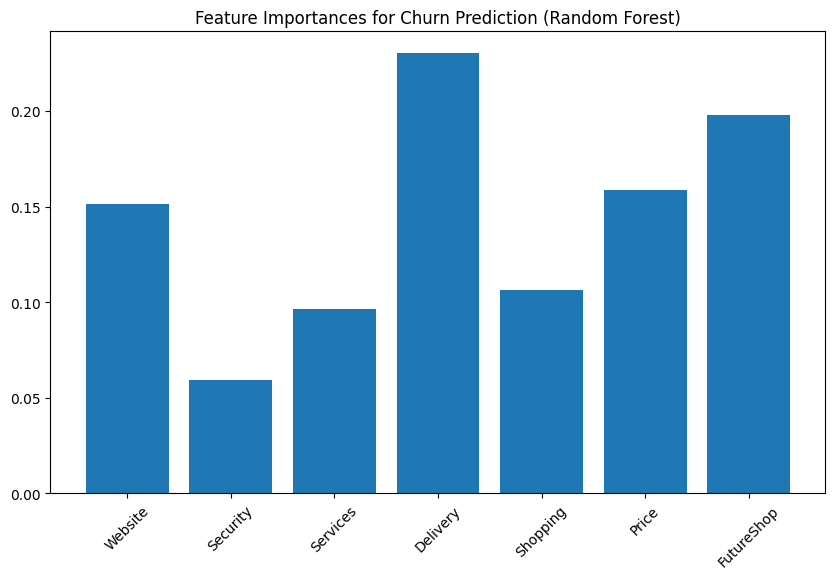

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=21)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (reduced overfitting): {accuracy_rf * 100:.2f}%")


y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f" Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# Feature Importance (Random Forest)
importances_rf = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances_rf)
plt.xticks(range(X.shape[1]), X.columns, rotation=45)
plt.title("Feature Importances for Churn Prediction (Random Forest)")
plt.show()

### Google Sheets as New Data for Predictions
We obtain the live responses from the Google forms survey present in our website. Using the customer feedback survey,we predict if the customer would churn or not

In [7]:
# Define scope and credentials
scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('ecomcw-d2dd4682a608.json', scope)

# Connect to Google Sheets
client = gspread.authorize(creds)

# Open the spreadsheet
sheet = client.open_by_key('1rZ90AxlEDotDPJ4_6HgO8IBaAPYi_Qc8MRUl2ag7aYQ')  # Google Sheet ID from link
worksheet = sheet.worksheet('Form Responses 1')  # Sheet name

In [8]:
# Get the records from the survey
google_sheet_data = pd.DataFrame(worksheet.get_all_records())
google_sheet_data.head(10)

,Timestamp,Name,CustomerID,How would you rate your overall experience with our website?,How would you rate the security of your payment and personal data on our website?,How would you rate your overall experience with our services?,How satisfied are you with our product delivery service?,How would you describe your shopping and buying experience?,How would you rate our product prices compared to value?,How likely are you to shop with us in the future,Feedback
0,3/12/2025 20:11:17,Fathima,C001,Good,Good,Good,Normal (Average delivery time),Reliable (Smooth and trustworthy process),Affordable,Yes,
1,3/14/2025 17:07:35,Melissa,C002,Bad,Good,Good,Confusing (Delayed or unclear delivery process),Normal,Very Good,No,"The prices are good, but the delivery was slow"
2,3/14/2025 17:09:14,Shaza,C003,Very Bad,Very Good,Good,Normal (Average delivery time),Normal,Affordable,Maybe,Overall a good experience
3,3/14/2025 17:11:33,Annie,C004,Bad,Good,Bad,Confusing (Delayed or unclear delivery process),Unreliable (Faced issues),Unfair (Too high for the value),No,
4,3/14/2025 17:12:20,Riya,C005,Very Good,Very Good,Good,Efficient (Fast and on-time),Normal,Affordable,Yes,
5,3/15/2025 23:37:19,Leah,C006,Good,Good,Very Bad,Confusing (Delayed or unclear delivery process),Unreliable (Faced issues),Unfair (Too high for the value),No,Prices are a bit expensive
6,3/17/2025 0:03:49,Antony,C007,Good,Good,Bad,Normal (Average delivery time),Unreliable (Faced issues),Unfair (Too high for the value),No,
7,3/17/2025 0:35:04,Jonnie,C008,Bad,Good,Very Good,Normal (Average delivery time),Reliable (Smooth and trustworthy process),Very Good,Yes,
8,3/20/2025 12:23:51,Test,C0020,Good,Very Good,Very Good,Normal (Average delivery time),Reliable (Smooth and trustworthy process),Very Good,Yes,
9,3/20/2025 12:32:44,TestCustomer,C0021,Good,Very Good,Very Good,Efficient (Fast and on-time),Reliable (Smooth and trustworthy process),Affordable,Yes,


In [9]:
# Map categorical data
mapping_dict = {
    'Very Bad': 1,
    'Bad': 2,
    'Good': 3,
    'Very Good': 4,
    'Confusing (Delayed or unclear delivery process)': 1,
    'Normal (Average delivery time)': 2,
    'Efficient (Fast and on-time)': 3,
    'Unreliable (Faced issues)': 1,
    'Normal': 2,
    'Reliable (Smooth and trustworthy process)': 3,
    'Unfair (Too high for the value)': 1,
    'Affordable': 2,
    'Very Good': 3,
    'No': 0,
    'Maybe': 1,
    'Yes': 2
}


In [10]:
# Clean column names
google_sheet_data.columns = google_sheet_data.columns.str.strip()

# Extract customer info
customer_info = google_sheet_data[['CustomerID', 'Name']].copy()

# Create a DataFrame for feedback
feedback_data = google_sheet_data[['CustomerID', 'Feedback']].copy()

# Drop unnecessary columns
google_sheet_data_modified = google_sheet_data.drop(['Timestamp', 'CustomerID', 'Name', 'Feedback'], axis=1)

# Rename columns
google_sheet_data_modified.rename(columns={
    'How satisfied are you with our product delivery service?': 'Delivery',
    'How would you rate our product prices compared to value?': 'Price',
    'How would you rate your overall experience with our website?': 'Website',
    'How would you describe your shopping and buying experience?': 'Shopping',
    'How likely are you to shop with us in the future': 'FutureShop',
    'How would you rate the security of your payment and personal data on our website?': 'Security',
    'How would you rate your overall experience with our services?': 'Services'
}, inplace=True)

# Map categorical data safely
columns_to_map = ['Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price', 'FutureShop']
for col in columns_to_map:
    if col in google_sheet_data_modified.columns:
        google_sheet_data_modified[col] = google_sheet_data_modified[col].map(mapping_dict).fillna(2)  # Safe mapping + filling
    else:
        print(f"Column '{col}' not found!")

# Align indices
customer_info.reset_index(drop=True, inplace=True)
google_sheet_data_modified.reset_index(drop=True, inplace=True)

In [17]:
# Predict churn
churn_predictions = cart_model.predict(google_sheet_data_modified)

# Loop and print
for idx in range(len(churn_predictions)):
    name = customer_info.iloc[idx]['Name']
    customer_id = customer_info.iloc[idx]['CustomerID']
    status = "CHURN" if churn_predictions[idx] == 'Yes' else "NOT CHURN"
    print(f"Customer '{name}' (ID: {customer_id}) is predicted to {status}.")


Customer 'Fathima' (ID: C001) is predicted to NOT CHURN.
Customer 'Melissa' (ID: C002) is predicted to CHURN.
Customer 'Shaza' (ID: C003) is predicted to NOT CHURN.
Customer 'Annie' (ID: C004) is predicted to CHURN.
Customer 'Riya' (ID: C005) is predicted to NOT CHURN.
Customer 'Leah' (ID: C006) is predicted to CHURN.
Customer 'Antony' (ID: C007) is predicted to NOT CHURN.
Customer 'Jonnie' (ID: C008) is predicted to NOT CHURN.
Customer 'Test' (ID: C0020) is predicted to NOT CHURN.
Customer 'TestCustomer' (ID: C0021) is predicted to NOT CHURN.


Hence, from our CART Model predictions we know that Customer C002, C004 and C006 will churn. <br>
Feedback Analysis: Customers like Melissa and Annie expressed dissatisfaction with the delivery service, citing delays and confusion. This is a critical area as it directly impacts customer experience.<br>
Action Plan: Implement a more robust delivery tracking system and improve communication channels to keep customers informed about the status of their orders.

In [18]:
# Define retention strategies
def recommend_action(customer):
    if customer['Delivery'] < 2:
        return "Improve delivery service with real-time tracking."
    if customer['Price'] < 2:
        return "Offer discounts or loyalty programs."
    if customer['Website'] < 2:
        return "Enhance website user experience."
    return "No urgent action needed."

# Apply recommendations
customer_info['Recommendation'] = google_sheet_data_modified.apply(recommend_action, axis=1)
# Display top 5 recommendations
print("Top 5 Customer Recommendations:")
print(customer_info[['CustomerID', 'Name', 'Recommendation']].head())


Top 5 Customer Recommendations:
  CustomerID     Name                                     Recommendation
0       C001  Fathima                           No urgent action needed.
1       C002  Melissa  Improve delivery service with real-time tracking.
2       C003    Shaza                   Enhance website user experience.
3       C004    Annie  Improve delivery service with real-time tracking.
4       C005     Riya                           No urgent action needed.


## Clustering to group customers


In [19]:
df = pd.DataFrame(google_sheet_data_modified)

# Encoding categorical data
label_encoders = {}
for column in ['Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price', 'FutureShop']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Website', 'Security', 'Services', 'Delivery', 'Shopping', 'Price', 'FutureShop']])
# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
df['Cluster'] = clusters

# Using Plotly for 2D scatter plot
fig = px.scatter(df, x='Price', y='Delivery', color='Cluster', symbol='FutureShop', title='Customer Feedback Clusters in 2D')
fig.update_traces(marker=dict(size=10, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(legend_title_text='Cluster')
fig.show()



c:\Users\fathi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
